# UCTransNet - ISIC2018
---

## Import packages & functions

In [1]:
from __future__ import print_function, division


import os
import sys
sys.path.append('../..')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import copy
import json
import importlib
import glob
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from torch.optim import Adam, SGD
from losses import DiceLoss, DiceLossWithLogtis
from torch.nn import BCELoss, CrossEntropyLoss

from utils import (
    show_sbs,
    load_config,
    _print,
)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# plt.ion()   # interactive mode

## Set the seed

In [2]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
import random
random.seed(0)

## Load the config

In [3]:
CONFIG_NAME = "isic/isic2018_uctransnet.yaml"
CONFIG_FILE_PATH = os.path.join("./configs", CONFIG_NAME)

In [4]:
config = load_config(CONFIG_FILE_PATH)
_print("Config:", "info_underline")
print(json.dumps(config, indent=2))
print(20*"~-", "\n")

Config:
{
  "run": {
    "mode": "train",
    "device": "gpu"
  },
  "transforms": "none",
  "dataset": {
    "class_name": "ISIC2018Dataset",
    "input_size": 224,
    "training": {
      "params": {
        "data_dir": "/path/to/datasets/ISIC2018"
      }
    },
    "validation": {
      "params": {
        "data_dir": "/path/to/datasets/ISIC2018"
      }
    },
    "number_classes": 2
  },
  "data_loader": {
    "train": {
      "batch_size": 16,
      "shuffle": true,
      "num_workers": 8,
      "pin_memory": true
    },
    "validation": {
      "batch_size": 16,
      "shuffle": false,
      "num_workers": 8,
      "pin_memory": true
    },
    "test": {
      "batch_size": 16,
      "shuffle": false,
      "num_workers": 4,
      "pin_memory": false
    }
  },
  "training": {
    "optimizer": {
      "name": "Adam",
      "params": {
        "lr": 0.0001
      }
    },
    "criterion": {
      "name": "DiceLoss",
      "params": {}
    },
    "scheduler": {
      "factor": 0.

## Dataset and Dataloader

In [6]:
from datasets.isic import ISIC2018DatasetFast
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

Length of trainig_dataset:	1815
Length of validation_dataset:	259
Length of test_dataset:		520

 Training


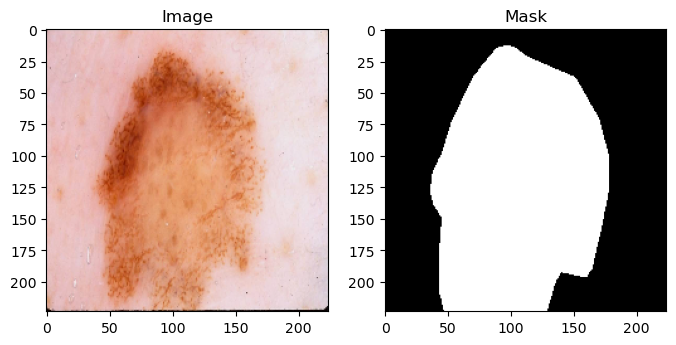

Validation


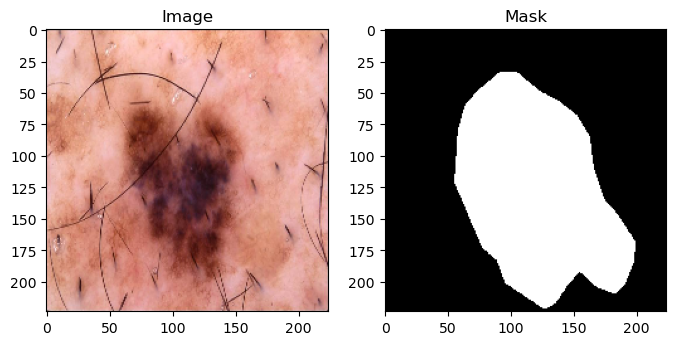

Test


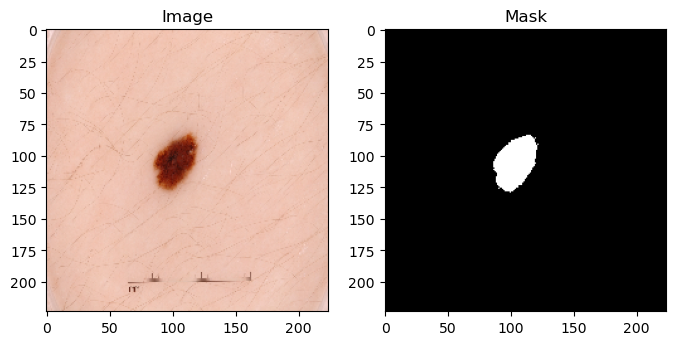

In [7]:
# ------------------- params --------------------
INPUT_SIZE = config['dataset']['input_size']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# ----------------- dataset --------------------
# preparing training dataset
tr_dataset = ISIC2018DatasetFast(mode="tr", one_hot=True)
vl_dataset = ISIC2018DatasetFast(mode="vl", one_hot=True)
te_dataset = ISIC2018DatasetFast(mode="te", one_hot=True)

# We consider 1815 samples for training, 259 samples for validation and 520 samples for testing
# !cat ~/deeplearning/skin/Prepare_ISIC2018.py

print(f"Length of trainig_dataset:\t{len(tr_dataset)}")
print(f"Length of validation_dataset:\t{len(vl_dataset)}")
print(f"Length of test_dataset:\t\t{len(te_dataset)}")


# prepare train dataloader
tr_dataloader = DataLoader(tr_dataset, **config['data_loader']['train'])

# prepare validation dataloader
vl_dataloader = DataLoader(vl_dataset, **config['data_loader']['validation'])

# prepare test dataloader
te_dataloader = DataLoader(te_dataset, **config['data_loader']['test'])

# -------------- test -----------------
# test and visualize the input data
for sample in tr_dataloader:
    img = sample['image']
    msk = sample['mask']
    print("\n Training")
    show_sbs(img[0], msk[0,1])
    break
    
for sample in vl_dataloader:
    img = sample['image']
    msk = sample['mask']
    print("Validation")
    show_sbs(img[0], msk[0,1])
    break
    
for sample in te_dataloader:
    img = sample['image']
    msk = sample['mask']
    print("Test")
    show_sbs(img[0], msk[0,1])
    break

### Device

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch device: {device}")

Torch device: cuda


## Metrics

In [12]:
metrics = torchmetrics.MetricCollection(
    [
        torchmetrics.F1Score(),
        torchmetrics.Accuracy(),
        torchmetrics.Dice(),
        torchmetrics.Precision(),
        torchmetrics.Specificity(),
        torchmetrics.Recall(),
        # IoU
        torchmetrics.JaccardIndex(2)
    ],
    prefix='train_metrics/'
)

# train_metrics
train_metrics = metrics.clone(prefix='train_metrics/').to(device)

# valid_metrics
valid_metrics = metrics.clone(prefix='valid_metrics/').to(device)

# test_metrics
test_metrics = metrics.clone(prefix='test_metrics/').to(device)

In [13]:
def make_serializeable_metrics(computed_metrics):
    res = {}
    for k, v in computed_metrics.items():
        res[k] = float(v.cpu().detach().numpy())
    return res

## Define validate function

In [14]:
def validate(model, criterion, vl_dataloader):
    model.eval()
    with torch.no_grad():
        
        evaluator = valid_metrics.clone().to(device)
        
        losses = []
        cnt = 0.
        for batch, batch_data in enumerate(vl_dataloader):
            imgs = batch_data['image']
            msks = batch_data['mask']
            
            cnt += msks.shape[0]
            
            imgs = imgs.to(device)
            msks = msks.to(device)
            
            preds = model(imgs)
            loss = criterion(preds, msks)
            losses.append(loss.item())
            
            
            preds_ = torch.argmax(preds, 1, keepdim=False).float()
            msks_ = torch.argmax(msks, 1, keepdim=False)
            evaluator.update(preds_, msks_)
        
#             _cml = f"curr_mean-loss:{np.sum(losses)/cnt:0.5f}"
#             _bl = f"batch-loss:{losses[-1]/msks.shape[0]:0.5f}"
#             iterator.set_description(f"Validation) batch:{batch+1:04d} -> {_cml}, {_bl}")
        
        # print the final results
        loss = np.sum(losses)/cnt
        metrics = evaluator.compute()
    
    return evaluator, loss

## Define train function

In [15]:
def train(
    model, 
    device, 
    tr_dataloader,
    vl_dataloader,
    config,
    
    criterion,
    optimizer,
    scheduler,
    
    save_dir='./',
    save_file_id=None,
):
    
    EPOCHS = tr_prms['epochs']
    
    torch.cuda.empty_cache()
    model = model.to(device)

    evaluator = train_metrics.clone().to(device)
    
    epochs_info = []
    best_model = None
    best_result = {}
    best_vl_loss = np.Inf
    for epoch in range(EPOCHS):
        model.train()
        
        evaluator.reset()
        tr_iterator = tqdm(enumerate(tr_dataloader))
        tr_losses = []
        cnt = 0
        for batch, batch_data in tr_iterator:
            imgs = batch_data['image']
            msks = batch_data['mask']
            
            imgs = imgs.to(device)
            msks = msks.to(device)
            
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, msks)
            loss.backward()
            optimizer.step()
            
            # evaluate by metrics
            preds_ = torch.argmax(preds, 1, keepdim=False).float()
            msks_ = torch.argmax(msks, 1, keepdim=False)
            evaluator.update(preds_, msks_)
            
            cnt += imgs.shape[0]
            tr_losses.append(loss.item())
            
            # write details for each training batch
            _cml = f"curr_mean-loss:{np.sum(tr_losses)/cnt:0.5f}"
            _bl = f"mean_batch-loss:{tr_losses[-1]/imgs.shape[0]:0.5f}"
            tr_iterator.set_description(f"Training) ep:{epoch:03d}, batch:{batch+1:04d} -> {_cml}, {_bl}")
            
        tr_loss = np.sum(tr_losses)/cnt
        
        # validate model
        vl_metrics, vl_loss = validate(model, criterion, vl_dataloader)
        if vl_loss < best_vl_loss:
            # find a better model
            best_model = model
            best_vl_loss = vl_loss
            best_result = {
                'tr_loss': tr_loss,
                'vl_loss': vl_loss,
                'tr_metrics': make_serializeable_metrics(evaluator.compute()),
                'vl_metrics': make_serializeable_metrics(vl_metrics.compute())
            }
        
        # write the final results
        epoch_info = {
            'tr_loss': tr_loss,
            'vl_loss': vl_loss,
            'tr_metrics': make_serializeable_metrics(evaluator.compute()),
            'vl_metrics': make_serializeable_metrics(vl_metrics.compute())
        }
        epochs_info.append(epoch_info)
#         epoch_tqdm.set_description(f"Epoch:{epoch+1}/{EPOCHS} -> tr_loss:{tr_loss}, vl_loss:{vl_loss}")
        evaluator.reset()
    
        scheduler.step(vl_loss)
  
    # save final results
    res = {
        'id': save_file_id,
        'config': config,
        'epochs_info': epochs_info,
        'best_result': best_result
    }
    fn = f"{save_file_id+'_' if save_file_id else ''}result.json"
    fp = os.path.join(config['model']['save_dir'],fn)
    with open(fp, "w") as write_file:
        json.dump(res, write_file, indent=4)

    # save model's state_dict
    fn = "last_model_state_dict.pt"
    fp = os.path.join(config['model']['save_dir'],fn)
    torch.save(model.state_dict(), fp)
    
    # save the best model's state_dict
    fn = "best_model_state_dict.pt"
    fp = os.path.join(config['model']['save_dir'], fn)
    torch.save(best_model.state_dict(), fp)
    
    return best_model, model, res

## Define test function

In [17]:
def test(model, te_dataloader):
    model.eval()
    with torch.no_grad():
        evaluator = test_metrics.clone().to(device)            
        for batch_data in tqdm(te_dataloader):
            imgs = batch_data['image']
            msks = batch_data['mask']
            
            imgs = imgs.to(device)
            msks = msks.to(device)
            
            preds = model(imgs)
            
            # evaluate by metrics
            preds_ = torch.argmax(preds, 1, keepdim=False).float()
            msks_ = torch.argmax(msks, 1, keepdim=False)
            evaluator.update(preds_, msks_)
            
    return evaluator

## Load and prepare model

In [18]:
# download weights

# !wget "https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz"
# !mkdir -p ../model/vit_checkpoint/imagenet21k
# !mv R50+ViT-B_16.npz ../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz

In [18]:
from models._uctransnet.UCTransNet import UCTransNet as Net
import models._uctransnet.Config as uct_config
config_vit = uct_config.get_CTranS_config()

model = Net(config_vit, **config['model']['params'])

torch.cuda.empty_cache()
model = model.to(device)
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

os.makedirs(config['model']['save_dir'], exist_ok=True)
model_path = f"{config['model']['save_dir']}/model_state_dict.pt"

if config['model']['load_weights']:
    model.load_state_dict(torch.load(model_path))
    print("Loaded pre-trained weights...")
    
    
# criterion_dice = DiceLoss()
criterion_dice = DiceLossWithLogtis()
# criterion_ce  = BCELoss()
criterion_ce  = CrossEntropyLoss()


def criterion(preds, masks):
    c_dice = criterion_dice(preds, masks)
    c_ce = criterion_ce(preds, masks)
    return 0.5*c_dice + 0.5*c_ce

tr_prms = config['training']
optimizer = globals()[tr_prms['optimizer']['name']](model.parameters(), **tr_prms['optimizer']['params'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', **tr_prms['scheduler'])

Number of parameters: 66430722


In [19]:
best_model, model, res = train(
    model, 
    device, 
    tr_dataloader,
    vl_dataloader,
    config,
    
    criterion,
    optimizer,
    scheduler,

    save_dir = config['model']['save_dir'],
    save_file_id = None,
)

In [20]:
te_metrics = test(best_model, te_dataloader)
te_metrics.compute()

In [29]:
f"{config['model']['save_dir']}"

'../saved_models/isic2018_uctransnet'

# Test the best inferred model
----

## Load the best model

In [34]:
best_model = Net(config_vit, **config['model']['params'])

torch.cuda.empty_cache()
best_model = best_model.to(device)

fn = "best_model_state_dict.pt"
os.makedirs(config['model']['save_dir'], exist_ok=True)
model_path = f"{config['model']['save_dir']}/{fn}"

best_model.load_state_dict(torch.load(model_path))
print("Loaded best model weights...")

Loaded best model weights...


## Evaluation

In [35]:
te_metrics = test(best_model, te_dataloader)
te_metrics.compute()

100%|██████████| 33/33 [00:06<00:00,  5.09it/s]


{'test_metrics/F1Score': tensor(0.8898, device='cuda:0'),
 'test_metrics/Accuracy': tensor(0.9546, device='cuda:0'),
 'test_metrics/Dice': tensor(0.8898, device='cuda:0'),
 'test_metrics/Precision': tensor(0.9100, device='cuda:0'),
 'test_metrics/Specificity': tensor(0.9770, device='cuda:0'),
 'test_metrics/Recall': tensor(0.8704, device='cuda:0'),
 'test_metrics/JaccardIndex': tensor(0.8729, device='cuda:0')}

## Plot graphs

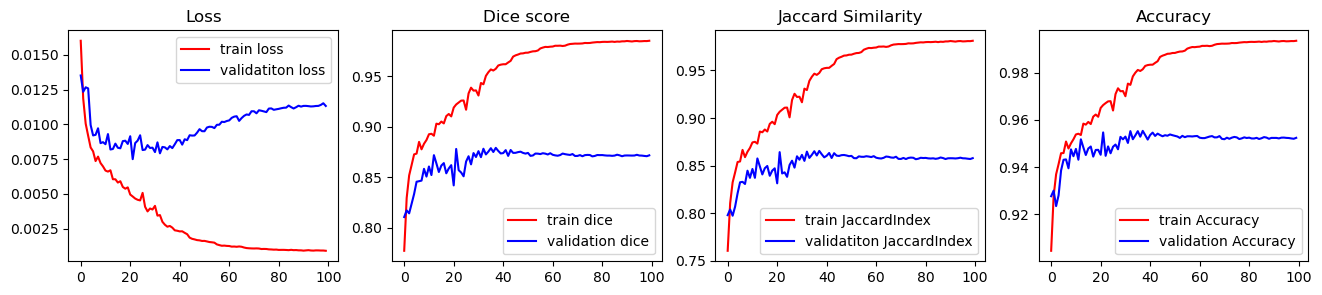

In [36]:
result_file_path = f"{config['model']['save_dir']}/result.json"
with open(result_file_path, 'r') as f:
    results = json.loads(''.join(f.readlines()))
epochs_info = results['epochs_info']

tr_losses = [d['tr_loss'] for d in epochs_info]
vl_losses = [d['vl_loss'] for d in epochs_info]
tr_dice = [d['tr_metrics']['train_metrics/Dice'] for d in epochs_info]
vl_dice = [d['vl_metrics']['valid_metrics/Dice'] for d in epochs_info]
tr_js = [d['tr_metrics']['train_metrics/JaccardIndex'] for d in epochs_info]
vl_js = [d['vl_metrics']['valid_metrics/JaccardIndex'] for d in epochs_info]
tr_acc = [d['tr_metrics']['train_metrics/Accuracy'] for d in epochs_info]
vl_acc = [d['vl_metrics']['valid_metrics/Accuracy'] for d in epochs_info]


_, axs = plt.subplots(1, 4, figsize=[16,3])

axs[0].set_title("Loss")
axs[0].plot(tr_losses, 'r-', label="train loss")
axs[0].plot(vl_losses, 'b-', label="validatiton loss")
axs[0].legend()

axs[1].set_title("Dice score")
axs[1].plot(tr_dice, 'r-', label="train dice")
axs[1].plot(vl_dice, 'b-', label="validation dice")
axs[1].legend()

axs[2].set_title("Jaccard Similarity")
axs[2].plot(tr_js, 'r-', label="train JaccardIndex")
axs[2].plot(vl_js, 'b-', label="validatiton JaccardIndex")
axs[2].legend()

axs[3].set_title("Accuracy")
axs[3].plot(tr_acc, 'r-', label="train Accuracy")
axs[3].plot(vl_acc, 'b-', label="validation Accuracy")
axs[3].legend()

plt.show()

In [37]:
epochs_info

[{'tr_loss': 0.016007727696547496,
  'vl_loss': 0.013512984666124734,
  'tr_metrics': {'train_metrics/F1Score': 0.777096152305603,
   'train_metrics/Accuracy': 0.9045920372009277,
   'train_metrics/Dice': 0.777096152305603,
   'train_metrics/Precision': 0.7940536141395569,
   'train_metrics/Specificity': 0.9448009133338928,
   'train_metrics/Recall': 0.7608477473258972,
   'train_metrics/JaccardIndex': 0.7605056762695312},
  'vl_metrics': {'valid_metrics/F1Score': 0.8105258941650391,
   'valid_metrics/Accuracy': 0.9277074337005615,
   'valid_metrics/Dice': 0.8105259537696838,
   'valid_metrics/Precision': 0.8017257452011108,
   'valid_metrics/Specificity': 0.9528667330741882,
   'valid_metrics/Recall': 0.8195214867591858,
   'valid_metrics/JaccardIndex': 0.797950029373169}},
 {'tr_loss': 0.01186129805470301,
  'vl_loss': 0.012338805497843327,
  'tr_metrics': {'train_metrics/F1Score': 0.829433023929596,
   'train_metrics/Accuracy': 0.9277817010879517,
   'train_metrics/Dice': 0.82943308

## Save images

In [40]:
from PIL import Image
import cv2
def skin_plot(img, gt, pred):
    img = np.array(img)
    gt = np.array(gt)
    pred = np.array(pred)
    edged_test = cv2.Canny(pred, 100, 255)
    contours_test, _ = cv2.findContours(edged_test, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    edged_gt = cv2.Canny(gt, 100, 255)
    contours_gt, _ = cv2.findContours(edged_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt_test in contours_test:
        cv2.drawContours(img, [cnt_test], -1, (0, 0, 255), 1)
    for cnt_gt in contours_gt:
        cv2.drawContours(img, [cnt_gt], -1, (0,255,0), 1)
    return img

#---------------------------------------------------------------------------------------------


save_imgs_dir = f"{config['model']['save_dir']}/visualized"

if not os.path.isdir(save_imgs_dir):
    os.mkdir(save_imgs_dir)

with torch.no_grad():
    for batch in tqdm(te_dataloader):
        imgs = batch['image']
        msks = batch['mask']
        ids = batch['id']
        
        preds = best_model(imgs.to(device))
        
        txm = imgs.cpu().numpy()
        tbm = torch.argmax(msks, 1).cpu().numpy()
        tpm = torch.argmax(preds, 1).cpu().numpy()
        tid = ids
        
        for idx in range(len(tbm)):
            img = np.moveaxis(txm[idx, :3], 0, -1)*255.
            img = np.ascontiguousarray(img, dtype=np.uint8)
            gt = np.uint8(tbm[idx]*255.)
            pred = np.where(tpm[idx]>0.5, 255, 0)
            pred = np.ascontiguousarray(pred, dtype=np.uint8)
            
            res_img = skin_plot(img, gt, pred)
            
            fid = tid[idx]
            Image.fromarray(img).save(f"{save_imgs_dir}/{fid}_img.png")
            Image.fromarray(res_img).save(f"{save_imgs_dir}/{fid}_img_gt_pred.png")


100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


In [31]:
f"{config['model']['save_dir']}/visualized"

'../saved_models/isic2018_transunet/visualized'